/home/codespace/.python/current/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/codespace/.python/current/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg   	std	min   	max   
0  	100   	-11425	0  	-11425	-11425
1  	86    	-11618	258.846	-12550	-11425
2  	88    	-11696.8	322.89 	-12600	-11425
3  	85    	-11735.2	359.098	-13150	-11425
4  	81    	-11716.2	384.34 	-13425	-11425
5  	83    	-11743.8	393.071	-13275	-11425
6  	84    	-11789.8	478.005	-14300	-11425
7  	82    	-11789.8	386.557	-13400	-11425
8  	84    	-11873  	480.62 	-13150	-11425
9  	84    	-11886.5	492.727	-13625	-11425
10 	86    	-11872.5	445.47 	-13175	-11425
11 	81    	-11888.5	447.694	-13050	-11425
12 	80    	-11889.8	463.925	-13250	-11425
13 	79    	-11914.2	518.932	-13400	-11425
14 	90    	-11908.8	494.588	-13300	-11425
15 	86    	-11930.2	485.004	-13350	-11425
16 	84    	-12010  	485.232	-14150	-11425
17 	90    	-12098.5	552.911	-13525	-11425
18 	84    	-12109  	592.785	-13725	-11425
19 	90    	-12079.2	589.693	-13500	-11425
20 	87    	-12056.8	567.691	-13500	-11425
21 	77    	-11964.5	506.152	-13475	-11425
22 	77    	-12038  	590.323	-13500	-11425
23 	84

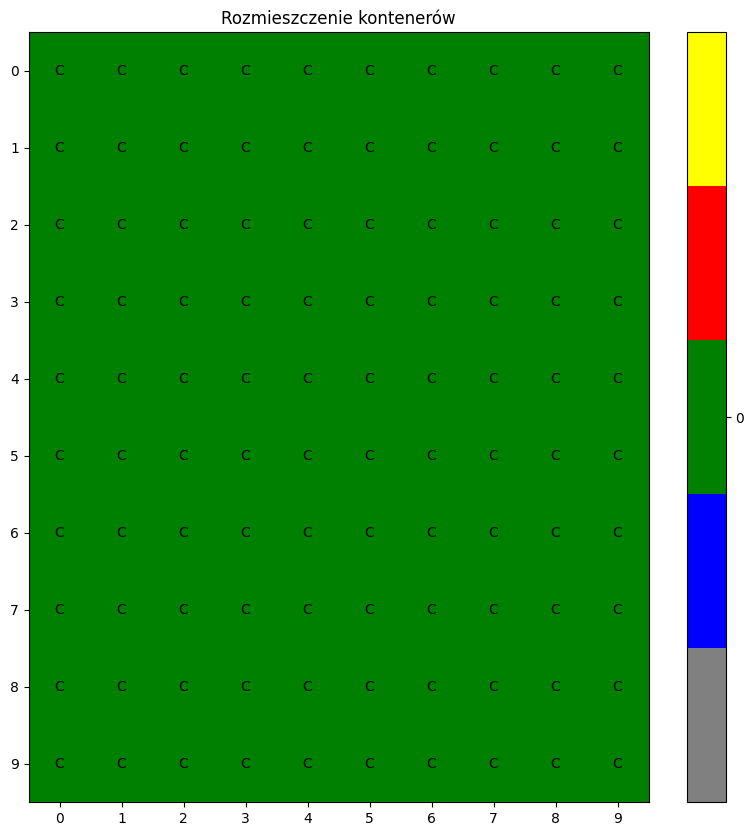

gen	nevals	avg   	std	min   	max   
0  	100   	-11425	0  	-11425	-11425
1  	82    	-11425	0  	-11425	-11425
2  	83    	-11425	0  	-11425	-11425
3  	95    	-11425	0  	-11425	-11425
4  	81    	-11425	0  	-11425	-11425
5  	82    	-11425	0  	-11425	-11425
6  	85    	-11425	0  	-11425	-11425
7  	82    	-11425	0  	-11425	-11425
8  	84    	-11425	0  	-11425	-11425
9  	80    	-11425	0  	-11425	-11425
10 	79    	-11425	0  	-11425	-11425
11 	89    	-11425	0  	-11425	-11425
12 	83    	-11425	0  	-11425	-11425
13 	87    	-11425	0  	-11425	-11425
14 	79    	-11425	0  	-11425	-11425
15 	91    	-11425	0  	-11425	-11425
16 	82    	-11425	0  	-11425	-11425
17 	75    	-11425	0  	-11425	-11425
18 	85    	-11425	0  	-11425	-11425
19 	87    	-11425	0  	-11425	-11425
20 	95    	-11425	0  	-11425	-11425
21 	86    	-11425	0  	-11425	-11425
22 	79    	-11425	0  	-11425	-11425
23 	86    	-11425	0  	-11425	-11425
24 	88    	-11425	0  	-11425	-11425
25 	89    	-11425	0  	-11425	-11425
26 	89    	-11425	0  	-11425

In [34]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Definicje typów kontenerów
CORRIDOR, RESIDENTIAL, KITCHEN, SANITARY, COMMON = range(5)
CONTAINER_TYPES = [CORRIDOR, RESIDENTIAL, KITCHEN, SANITARY, COMMON]

# Wymiary siatki
GRID_WIDTH, GRID_HEIGHT = 10, 10

# Kolory i etykiety dla wizualizacji
colors = ['grey', 'blue', 'green', 'red', 'yellow']
labels = ['Korytarz', 'Mieszkalny', 'Kuchnia', 'Sanitariaty', 'Przestrzeń wspólna']
cmap = mcolors.ListedColormap(colors)


def fitnessFunction(individual):
    grid = np.array(individual).reshape(GRID_HEIGHT, GRID_WIDTH)

    # Liczba kontenerów różnego typu
    num_residential = np.sum(grid == RESIDENTIAL)
    num_kitchen = np.sum(grid == KITCHEN)
    num_common = np.sum(grid == COMMON)
    num_sanitary = np.sum(grid == SANITARY)

    # Oblicz średnią odległość od kontenerów mieszkalnych do innych typów kontenerów
    kitchen_distance, sanitary_distance, common_distance, = calculateAverageDistance(grid)

    # Optymalne proporcje
    ideal_residential_per_kitchen = 5
    ideal_residential_per_common = 10
    ideal_residential_per_sanitary = 3

    # Obliczenie kar za nieoptymalne proporcje
    kitchen_score = abs(num_residential - ideal_residential_per_kitchen * num_kitchen) * 5
    common_score = abs(num_residential - ideal_residential_per_common * num_common) * 5
    sanitary_score = abs(num_residential - ideal_residential_per_sanitary * num_sanitary) * 5

    # Ocena dostępności do korytarza
    accessibility_score = evaluateAccessibility(grid)

    residential_score = num_residential * (-20)

    corridor_score = isCorridorFullyConnectedScore(grid) * 25

    # Łączna ocena
    total_score = kitchen_score + common_score + sanitary_score + accessibility_score + \
                  kitchen_distance * 18 + sanitary_distance * 30 + common_distance * 9 + residential_score + corridor_score
    return total_score*(-1),


def calculateAverageDistance(grid):
    def average_distance(locations1, locations2):
        total_distance = 0
        num_pairs = 0
        ## Szukamy dystansu do najbliższego kontenera
        for loc1 in locations1:
            min_distance = 100
            for loc2 in locations2:
                distance = manhattanDistance(loc1, loc2)
                min_distance = min(min_distance, distance)
            total_distance += min_distance
            num_pairs += 1

        return total_distance / num_pairs if num_pairs > 0 else 200

    residential_locations = [(i, j) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) if grid[i][j] == RESIDENTIAL]
    kitchen_locations = [(i, j) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) if grid[i][j] == KITCHEN]
    sanitary_locations = [(i, j) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) if grid[i][j] == SANITARY]
    common_locations = [(i, j) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) if grid[i][j] == COMMON]

    kitchen_average_distance = average_distance(residential_locations, kitchen_locations)
    sanitary_average_distance = average_distance(residential_locations, sanitary_locations)
    common_average_distance = average_distance(residential_locations, common_locations)

    return kitchen_average_distance, sanitary_average_distance, common_average_distance


def runCorridor(grid, true_matrix, i ,j):
    true_matrix[i][j] = 1
    if (j + 1 < len(grid[i]) and grid[i][j + 1] == CORRIDOR and true_matrix[i][j+1] == 0):
        runCorridor(grid, true_matrix, i, j+1)

    if(i + 1 < len(grid) and grid[i + 1][j] == CORRIDOR and true_matrix[i+1][j] == 0):
        runCorridor(grid, true_matrix, i+1, j)

    if (j - 1 >= 0 and grid[i][j - 1] == CORRIDOR and true_matrix[i][j-1] == 0):
        runCorridor(grid, true_matrix, i, j-1)

    if (i - 1 >= 0 and grid[i - 1][j] == CORRIDOR and true_matrix[i-1][j] == 0):
        runCorridor(grid, true_matrix, i-1, j)


def isCorridorFullyConnectedScore(grid):
    number_of_corridors = 0
    true_matrix = np.zeros((GRID_WIDTH,GRID_HEIGHT))
    for i in range(GRID_WIDTH):
        for j in range(GRID_HEIGHT):
            if grid[i][j] == CORRIDOR and true_matrix[i][j] == 0:
                number_of_corridors += 1
                runCorridor(grid, true_matrix, i ,j)
            else:
                true_matrix[i][j] = 1

    return number_of_corridors

def manhattanDistance(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])


def isDirectlyConnectedToCorridor(grid, i, j):
    # Sprawdza, czy dana komórka jest bezpośrednio połączona z korytarzem
    return (j + 1 < len(grid[i]) and grid[i][j + 1] == CORRIDOR) or (
            i + 1 < len(grid) and grid[i + 1][j] == CORRIDOR) or (
            j - 1 > 0 and grid[i][j - 1] == CORRIDOR) or (
            i - 1 > 0 and grid[i - 1][j] == CORRIDOR)


def isCorridorConnectedToCorridor(grid, i, j):
    # Sprawdza, czy dana komórka korytarza jest połączona z więcej niż jednym korytarzem lub jest na brzegu gridu
    numberOfNeighbourCorridors = (int(j + 1 < len(grid[i]) and grid[i][j + 1] == CORRIDOR) + int(
        i + 1 < len(grid) and grid[i + 1][j] == CORRIDOR) + int(
        j - 1 >= 0 and grid[i][j - 1] == CORRIDOR) + int(
        i - 1 >= 0 and grid[i - 1][j] == CORRIDOR))
    logic_value = (numberOfNeighbourCorridors > 1) or \
                  (((j + 1 > len(grid[i])) or (j - 1 < 0) or (i + 1 > len(grid)) or (i - 1 < 0))
                   and numberOfNeighbourCorridors > 0)
    return logic_value


def evaluateAccessibility(grid):
    accessibility_score = 0

    # Sprawdzenie, czy każdy kontener jest połączony z korytarzem
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if grid[i][j] in [RESIDENTIAL, KITCHEN, COMMON, SANITARY]:
                if not isDirectlyConnectedToCorridor(grid, i, j):
                    accessibility_score += 30  # Duża kara za brak bezpośredniego połączenia
            if grid[i][j] == CORRIDOR:
                if not isCorridorConnectedToCorridor(grid, i, j):
                    accessibility_score += 100  # Kara za niepołączone ze sobą korytarze

    return accessibility_score


# Inicjalizacja DEAP
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_item", lambda: CORRIDOR)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, GRID_WIDTH * GRID_HEIGHT)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(CONTAINER_TYPES) - 1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


def main():
    # Inicjalizacja populacji
    pop = toolbox.population(n=100)

    # Inicjalizacja Hall of Fame (najlepsze znalezione rozwiązanie)
    hof = tools.HallOfFame(1)

    # Statystyki
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Parametry algorytmu ewolucyjnego
    prob_cross = 0.7
    prob_mut = 0.5
    num_generations = 100

    # Uruchomienie algorytmu ewolucyjnego
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=prob_cross, mutpb=prob_mut,
                                   ngen=num_generations, stats=stats,
                                   halloffame=hof, verbose=True)

    # Wizualizacja najlepszego rozwiązania
    best = np.array(hof[0]).reshape(GRID_HEIGHT, GRID_WIDTH)
    print("Najlepsze znalezione rozwiązanie:")
    print(best)
    plotGrid(best)

    return pop, log, hof

# Wizualizacja
def plotGrid(grid):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(grid, cmap=cmap, aspect='auto')

    # Dodanie etykiet do siatki
    for (j, i), value in np.ndenumerate(grid):
        text = ''
        if value == RESIDENTIAL:
            text = 'M'  # Mieszkalny
        elif value == KITCHEN:
            text = 'K'  # Kuchnia
        elif value == SANITARY:
            text = 'S'  # Sanitariaty
        elif value == COMMON:
            text = 'W'  # Przestrzeń wspólna
        elif value == CORRIDOR:
            text = 'C'  # Korytarz
        plt.text(i, j, text, ha='center', va='center', color='black')

    plt.colorbar(cax, ticks=np.arange(len(colors)))
    plt.xticks(ticks=np.arange(GRID_WIDTH), labels=np.arange(GRID_WIDTH))
    plt.yticks(ticks=np.arange(GRID_HEIGHT), labels=np.arange(GRID_HEIGHT))
    plt.title("Rozmieszczenie kontenerów")
    plt.show()
    
#TESTY

def test_selection_methods():
    selection_configs = [
        (tools.selTournament, {"tournsize": 3}),
        (tools.selRoulette, {}),
        # (tools.selBest, {}),
        (tools.selDoubleTournament, {"fitness_size": 3, "parsimony_size": 1.4, "fitness_first": True}),
        # (tools.selRandom, {})
    ]
    selection_names = []
    avg_selection_results = []
    best_selection_results = []

    for selection, params in selection_configs:
        try:
            toolbox.register("select", selection, **params)
            final_population, _, _ = main()

            avg_fitness = np.mean([ind.fitness.values[0] for ind in final_population])
            best_fitness = max([ind.fitness.values[0] for ind in final_population])  # Zmiana na max dla najlepszego przystosowania
            
            avg_selection_results.append(avg_fitness)
            best_selection_results.append(best_fitness)
            selection_names.append(selection.__name__)  # Dodaj nazwę metody do listy
        except Exception as e:
            print(f"Błąd przy metodzie {selection.__name__}: {e}")

    x = np.arange(len(selection_names))  # Pozycje etykiet dla wykresów
    width = 0.35  # Szerokość słupków

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, avg_selection_results, width, label='Średnia')
    rects2 = ax.bar(x + width/2, best_selection_results, width, label='Najlepsze')

    ax.set_xlabel('Metoda selekcji')
    ax.set_ylabel('Wartości przystosowania')
    ax.set_title('Porównanie metod selekcji')
    ax.set_xticks(x)
    ax.set_xticklabels(selection_names)
    ax.legend()

    plt.show()

def test_mutation_methods():
    mutation_configs = [
        (tools.mutGaussian, {"mu": 0, "sigma": 0.1, "indpb": 0.2}),
        (tools.mutShuffleIndexes, {"indpb": 0.2}),
        (tools.mutFlipBit, {"indpb": 0.05}),
        (tools.mutUniformInt, {"low": 0, "up": len(CONTAINER_TYPES) - 1, "indpb": 0.1})
    ]
    mutation_names = []
    avg_mutation_results = []
    best_mutation_results = []

    for mutation, params in mutation_configs:
        try:
            toolbox.register("mutate", mutation, **params)
            toolbox.register("select", tools.selTournament, tournsize=3)
            final_population, _, _ = main()

            avg_fitness = np.mean([ind.fitness.values[0] for ind in final_population])
            best_fitness = max([ind.fitness.values[0] for ind in final_population])

            avg_mutation_results.append(avg_fitness)
            best_mutation_results.append(best_fitness)
            mutation_names.append(mutation.__name__)
        except Exception as e:
            print(f"Błąd przy metodzie {mutation.__name__}: {e}")

    x = np.arange(len(mutation_names))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, avg_mutation_results, width, label='Średnia')
    rects2 = ax.bar(x + width/2, best_mutation_results, width, label='Najlepsze')

    ax.set_xlabel('Metoda mutacji')
    ax.set_ylabel('Wartości przystosowania')
    ax.set_title('Porównanie metod mutacji z użyciem selTournament')
    ax.set_xticks(x)
    ax.set_xticklabels(mutation_names)
    ax.legend()

    plt.show()

test_mutation_methods()


# Wywołanie funkcji eksperymentującej
if __name__ == "__main__":
    # test_selection_methods()
    test_mutation_methods()
